# Introduction

In this notebook, we will implement a link predection task within a biological network, which is a type of binary classification problem. Our goal is to predict whether a connection (or edge) exists between two nodes in a graph. In this context, the nodes represent biological entities like diseases, genes, and proteins, and the edges represent the relationships between them, such as disease-gene associations or protein-protein interactions.

In [1]:
import pandas as pd
import networkx as nx
import sys
sys.path.insert(1, '../src')
from helper import plot_community_detection, visualize_graphs
import time
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from model_evaluation import ModelEvaluation
from joblib import dump, load


# Data Preparation

We've previously collected partial datasets from Open Targets and String DB using fetch requests and have combined them into a Protein-Protein Interaction (PPI) network for Disease X. This means we've successfully identified the positive proteins associated with our target disease.

However, there's a challenge: when using the Open Targets API to fetch data, each query returns only 50 results at a time, as highlighted by Andrew in his [video](https://youtu.be/_sZR0VxpwqE?si=wAh5bey78LohVPME&t=2383), and [slides](https://docs.google.com/presentation/d/16_99z8Su8j8HbFuhxSlTRZZCW67hNpk0To7UfpoeiTg/edit#slide=id.ged473f4bb5_4_16). In other simple words, to get the full dataset for a specific disease, we need to run the query multiple times, changing the page index each time.

Following their recommended approach, we used [BigQuery](https://community.opentargets.org/t/returning-all-associations-data-using-the-platform-api/324/2#how-do-i-access-associations-data-using-bigquery-2) to retrieve the complete dataset for the disease.

[SQL Query](../src/alzheimer_disease_associations.sql) can be found here

In [2]:
disease_df = pd.read_csv('../data/raw/alzheimer_disease_detailed.csv')
disease_df

target_id target_approved_symbol     disease_id  \
0     ENSG00000142192                    APP  MONDO_0004975   
1     ENSG00000142192                    APP  MONDO_0004975   
2     ENSG00000142192                    APP  MONDO_0004975   
3     ENSG00000142192                    APP  MONDO_0004975   
4     ENSG00000142192                    APP  MONDO_0004975   
...               ...                    ...            ...   
5978  ENSG00000094916                   CBX5  MONDO_0004975   
5979  ENSG00000075303               SLC25A40  MONDO_0004975   
5980  ENSG00000116001                   TIA1  MONDO_0004975   
5981  ENSG00000155886                SLC24A2  MONDO_0004975   
5982  ENSG00000166454                  ATMIN  MONDO_0004975   

           disease_name  overall_direct_score       datasource_id  \
0     Alzheimer disease              0.752949  ot_genetics_portal   
1     Alzheimer disease              0.752949  ot_genetics_portal   
2     Alzheimer disease              0.752949  ot_genetics_portal   
3     Alzheimer disease              0.752949  ot_genetics_portal   
4     Alzheimer disease              0.752949              chembl   
...                 ...                   ...                 ...   
5978  Alzheimer disease              0.001051    expression_atlas   
5979  Alzheimer disease              0.001033    expression_atlas   
5980  Alzheimer disease              0.001028    expression_atlas   
5981  Alzheimer disease              0.001017    expression_atlas   
5982  Alzheimer disease              0.001016    expression_atlas   

     datasource_datatype_id  datasource_direct_score  \
0       genetic_association                 0.465692   
1       genetic_association                 0.465692   
2       genetic_association                 0.465692   
3       genetic_association                 0.465692   
4                known_drug                 0.912335   
...                     ...                      ...   
5978         rna_expression                 0.008642   
5979         rna_expression                 0.008496   
5980         rna_expression                 0.008456   
5981         rna_expression                 0.008363   
5982         rna_expression                 0.008358   

      datasource_direct_evidence_count          datatype_id  \
0                                    1           known_drug   
1                                    1     affected_pathway   
2                                    1           literature   
3                                    1  genetic_association   
4                                   90           known_drug   
...                                ...                  ...   
5978                                 1       rna_expression   
5979                                 1       rna_expression   
5980                                 1       rna_expression   
5981                                 1       rna_expression   
5982                                 1       rna_expression   

      datatype_direct_score  datatype_direct_evidence_count  \
0                  0.912335                              90   
1                  0.607931                               1   
2                  0.365378                              54   
3                  0.818363                             333   
4                  0.912335                              90   
...                     ...                             ...   
5978               0.008642                               1   
5979               0.008496                               1   
5980               0.008456                               1   
5981               0.008363                               1   
5982               0.008358                               1   

      overall_indirect_score  overall_indirect_evidence_count  
0                   0.843813                             1263  
1                   0.843813                             1263  
2                   0.843813                   

Similary fetching STRING database will give us limited data too, we needed to dwnload the files needed, as mentioned by Sam earlier, and combine them inorder to get the protein names


In order to download the necessary files, follow these steps:
1. Go to [STRING Database](https://string-db.org/cgi/download) download page.
2. Select "Homo Sapiens"
3. Download the following files:
    - `9606.protein.links.detailed.v12.0.txt.gz`
    - `9606.protein.info.v12.0.txt`

In [3]:
raw_string_interactions = pd.read_csv('../data/raw/9606.protein.links.detailed.v12.0.txt', sep=r'\s+', header=0)
raw_protein_info = pd.read_csv('../data/raw/9606.protein.info.v12.0.txt', sep='\t', header=0)

In [4]:
raw_string_interactions

protein1              protein2  neighborhood  fusion  \
0         9606.ENSP00000000233  9606.ENSP00000356607             0       0   
1         9606.ENSP00000000233  9606.ENSP00000427567             0       0   
2         9606.ENSP00000000233  9606.ENSP00000253413             0       0   
3         9606.ENSP00000000233  9606.ENSP00000493357             0       0   
4         9606.ENSP00000000233  9606.ENSP00000324127             0       0   
...                        ...                   ...           ...     ...   
13715399  9606.ENSP00000501317  9606.ENSP00000475489             0       0   
13715400  9606.ENSP00000501317  9606.ENSP00000370447             0       0   
13715401  9606.ENSP00000501317  9606.ENSP00000312272             0       0   
13715402  9606.ENSP00000501317  9606.ENSP00000402092             0       0   
13715403  9606.ENSP00000501317  9606.ENSP00000404074             0       0   

          cooccurence  coexpression  experimental  database  textmining  \
0                   0            45           134         0          81   
1                   0             0           128         0          70   
2                   0           118            49         0          69   
3                   0            56            53         0         457   
4                   0             0            46         0         197   
...               ...           ...           ...       ...         ...   
13715399            0            60            99         0         126   
13715400            0            55           111         0          79   
13715401            0             0             0         0         227   
13715402            0             0            67         0         146   
13715403            0            49            63         0         227   

          combined_score  
0                    173  
1                    154  
2                    151  
3                    471  
4                    201  
...                  ...  
13715399             195  
13715400             158  
13715401             226  
13715402             169  
13715403             251  

[13715404 rows x 10 columns]

In [5]:
raw_protein_info

#string_protein_id preferred_name  protein_size  \
0      9606.ENSP00000000233           ARF5           180   
1      9606.ENSP00000000412           M6PR           277   
2      9606.ENSP00000001008          FKBP4           459   
3      9606.ENSP00000001146        CYP26B1           512   
4      9606.ENSP00000002125        NDUFAF7           441   
...                     ...            ...           ...   
19694  9606.ENSP00000501254        ALDH3B2           385   
19695  9606.ENSP00000501259        FAM163B           166   
19696  9606.ENSP00000501265           NWD1          1432   
19697  9606.ENSP00000501277           LDB1           411   
19698  9606.ENSP00000501317           RFX7          1460   

                                              annotation  
0      ADP-ribosylation factor 5; GTP-binding protein...  
1      Cation-dependent mannose-6-phosphate receptor;...  
2      Peptidyl-prolyl cis-trans isomerase FKBP4, N-t...  
3      Cytochrome P450 26B1; Involved in the metaboli...  
4      Protein arginine methyltransferase NDUFAF7, mi...  
...                                                  ...  
19694  Aldehyde dehydrogenase family 3 member B2; Oxi...  
19695  Protein FAM163B; Family with sequence similari...  
19696  NACHT domain- and WD repeat-containing protein...  
19697  LIM domain-binding protein 1; Binds to the LIM...  
19698  DNA-binding protein RFX7; Regulatory factor X7...  

[19699 rows x 4 columns]

In [6]:
# Process STRING database interaction data by adding protein names and sizes

raw_protein_info.set_index('#string_protein_id', inplace=True)
protein_id_to_info = raw_protein_info[['preferred_name', 'protein_size']].to_dict(orient='index')

def get_protein_info(protein_id, detail):
    return protein_id_to_info.get(protein_id, {}).get(detail, ' ')

raw_string_interactions['protein1_name'] = raw_string_interactions['protein1'].apply(lambda x: get_protein_info(x, 'preferred_name'))
raw_string_interactions['protein1_size'] = raw_string_interactions['protein1'].apply(lambda x: get_protein_info(x, 'protein_size'))

raw_string_interactions['protein2_name'] = raw_string_interactions['protein2'].apply(lambda x: get_protein_info(x, 'preferred_name'))
raw_string_interactions['protein2_size'] = raw_string_interactions['protein2'].apply(lambda x: get_protein_info(x, 'protein_size'))

columns = [
    'protein1', 'protein2', 'protein1_name', 'protein2_name',
    'protein1_size', 'protein2_size', 'combined_score', 'neighborhood', 'fusion',
    'cooccurence', 'coexpression', 'experimental', 'database',
    'textmining'
]

string_interactions = raw_string_interactions[columns]
string_interactions['combined_score'] = string_interactions['combined_score']/1000
string_interactions.to_csv('../data/interim/string_interactions.txt', sep='\t', index=False)
string_interactions

protein1              protein2 protein1_name  \
0         9606.ENSP00000000233  9606.ENSP00000356607          ARF5   
1         9606.ENSP00000000233  9606.ENSP00000427567          ARF5   
2         9606.ENSP00000000233  9606.ENSP00000253413          ARF5   
3         9606.ENSP00000000233  9606.ENSP00000493357          ARF5   
4         9606.ENSP00000000233  9606.ENSP00000324127          ARF5   
...                        ...                   ...           ...   
13715399  9606.ENSP00000501317  9606.ENSP00000475489          RFX7   
13715400  9606.ENSP00000501317  9606.ENSP00000370447          RFX7   
13715401  9606.ENSP00000501317  9606.ENSP00000312272          RFX7   
13715402  9606.ENSP00000501317  9606.ENSP00000402092          RFX7   
13715403  9606.ENSP00000501317  9606.ENSP00000404074          RFX7   

         protein2_name  protein1_size  protein2_size  combined_score  \
0              RALGPS2            180            583           0.173   
1                FHDC1            180           1143           0.154   
2             ATP6V1E1            180            226           0.151   
3                CYTH2            180            400           0.471   
4                 PSD3            180           1047           0.201   
...                ...            ...            ...             ...   
13715399      MPHOSPH9           1460           1183           0.195   
13715400           VCX           1460            206           0.158   
13715401         YPEL2           1460            119           0.226   
13715402         SAMD3           1460            544           0.169   
13715403        ZSCAN9           1460            445           0.251   

          neighborhood  fusion  cooccurence  coexpression  experimental  \
0                    0       0            0            45           134   
1                    0       0            0             0           128   
2                    0       0            0           118            49   
3                    0       0            0            56            53   
4                    0       0            0             0            46   
...                ...     ...          ...           ...           ...   
13715399             0       0            0            60            99   
13715400             0       0            0            55           111   
13715401             0       0            0             0             0   
13715402             0       0            0             0            67   
13715403             0       0            0            49            63   

          database  textmining  
0                0          81  
1                0          70  
2                0          69  
3                0         457  
4                0         197  
...            ...         ...  
13715399         0         126  
13715400         0          79  
13715401         0         227  
13715402         0         146  
13715403         0         227  

[13715404 rows x 14 columns]

# Experiment 1: Using a Sample from STRING Database


In this experiment, we extract a sample from the STRING database that matches the length of our Alzheimer's disease dataset `disease_df`. The goal is to create a composed graph that represents a disease-gene and protein-protein interactions and to evaluate various classification models on this sample

In [7]:
# take a sample from the STRING db with same length as our disease data
sample_string_interactions = string_interactions.sample(n=len(disease_df), random_state=42)
sample_string_interactions.reset_index(drop=True, inplace=True)
sample_string_interactions

protein1              protein2 protein1_name protein2_name  \
0     9606.ENSP00000282928  9606.ENSP00000360493          ZIC1         RUNX2   
1     9606.ENSP00000264634  9606.ENSP00000360973         WNT5A         AGTR2   
2     9606.ENSP00000379601  9606.ENSP00000380432        RAB27A           INS   
3     9606.ENSP00000219197  9606.ENSP00000410732         CBLN1        GABRG2   
4     9606.ENSP00000307766  9606.ENSP00000438388         HTR1E         KIF1A   
...                    ...                   ...           ...           ...   
5978  9606.ENSP00000247219  9606.ENSP00000425561         TBPL2         EIF4E   
5979  9606.ENSP00000379873  9606.ENSP00000386593         HLA-A         PBRM1   
5980  9606.ENSP00000261023  9606.ENSP00000252050         ITGAV          CUL9   
5981  9606.ENSP00000263753  9606.ENSP00000493712          SGO1         RAD51   
5982  9606.ENSP00000239223  9606.ENSP00000260302         DUSP1         MMP13   

      protein1_size  protein2_size  combined_score  neighborhood  fusion  \
0               447            521           0.280             0       0   
1               380            363           0.201             0       0   
2               221            110           0.607             0       0   
3               193            515           0.279             0       0   
4               365           1791           0.172             0       0   
...             ...            ...             ...           ...     ...   
5978            375            248           0.168             0       0   
5979            365           1634           0.150             0       0   
5980           1048           2517           0.302             0       0   
5981            561            340           0.593             0       0   
5982            367            471           0.222             0       0   

      cooccurence  coexpression  experimental  database  textmining  
0               0             0            67         0         261  
1               0            56             0         0         189  
2               0             0             0       400         373  
3               0           255             0         0          72  
4               0           137             0         0          80  
...           ...           ...           ...       ...         ...  
5978            0           108             0         0         106  
5979            0             0             0         0         151  
5980            0            55           292         0           0  
5981            0           467           162         0         162  
5982            0            65             0         0         203  

[5983 rows x 14 columns]

Graphs construction completed at 0.44 seconds
Graphs composed at 0.03 seconds


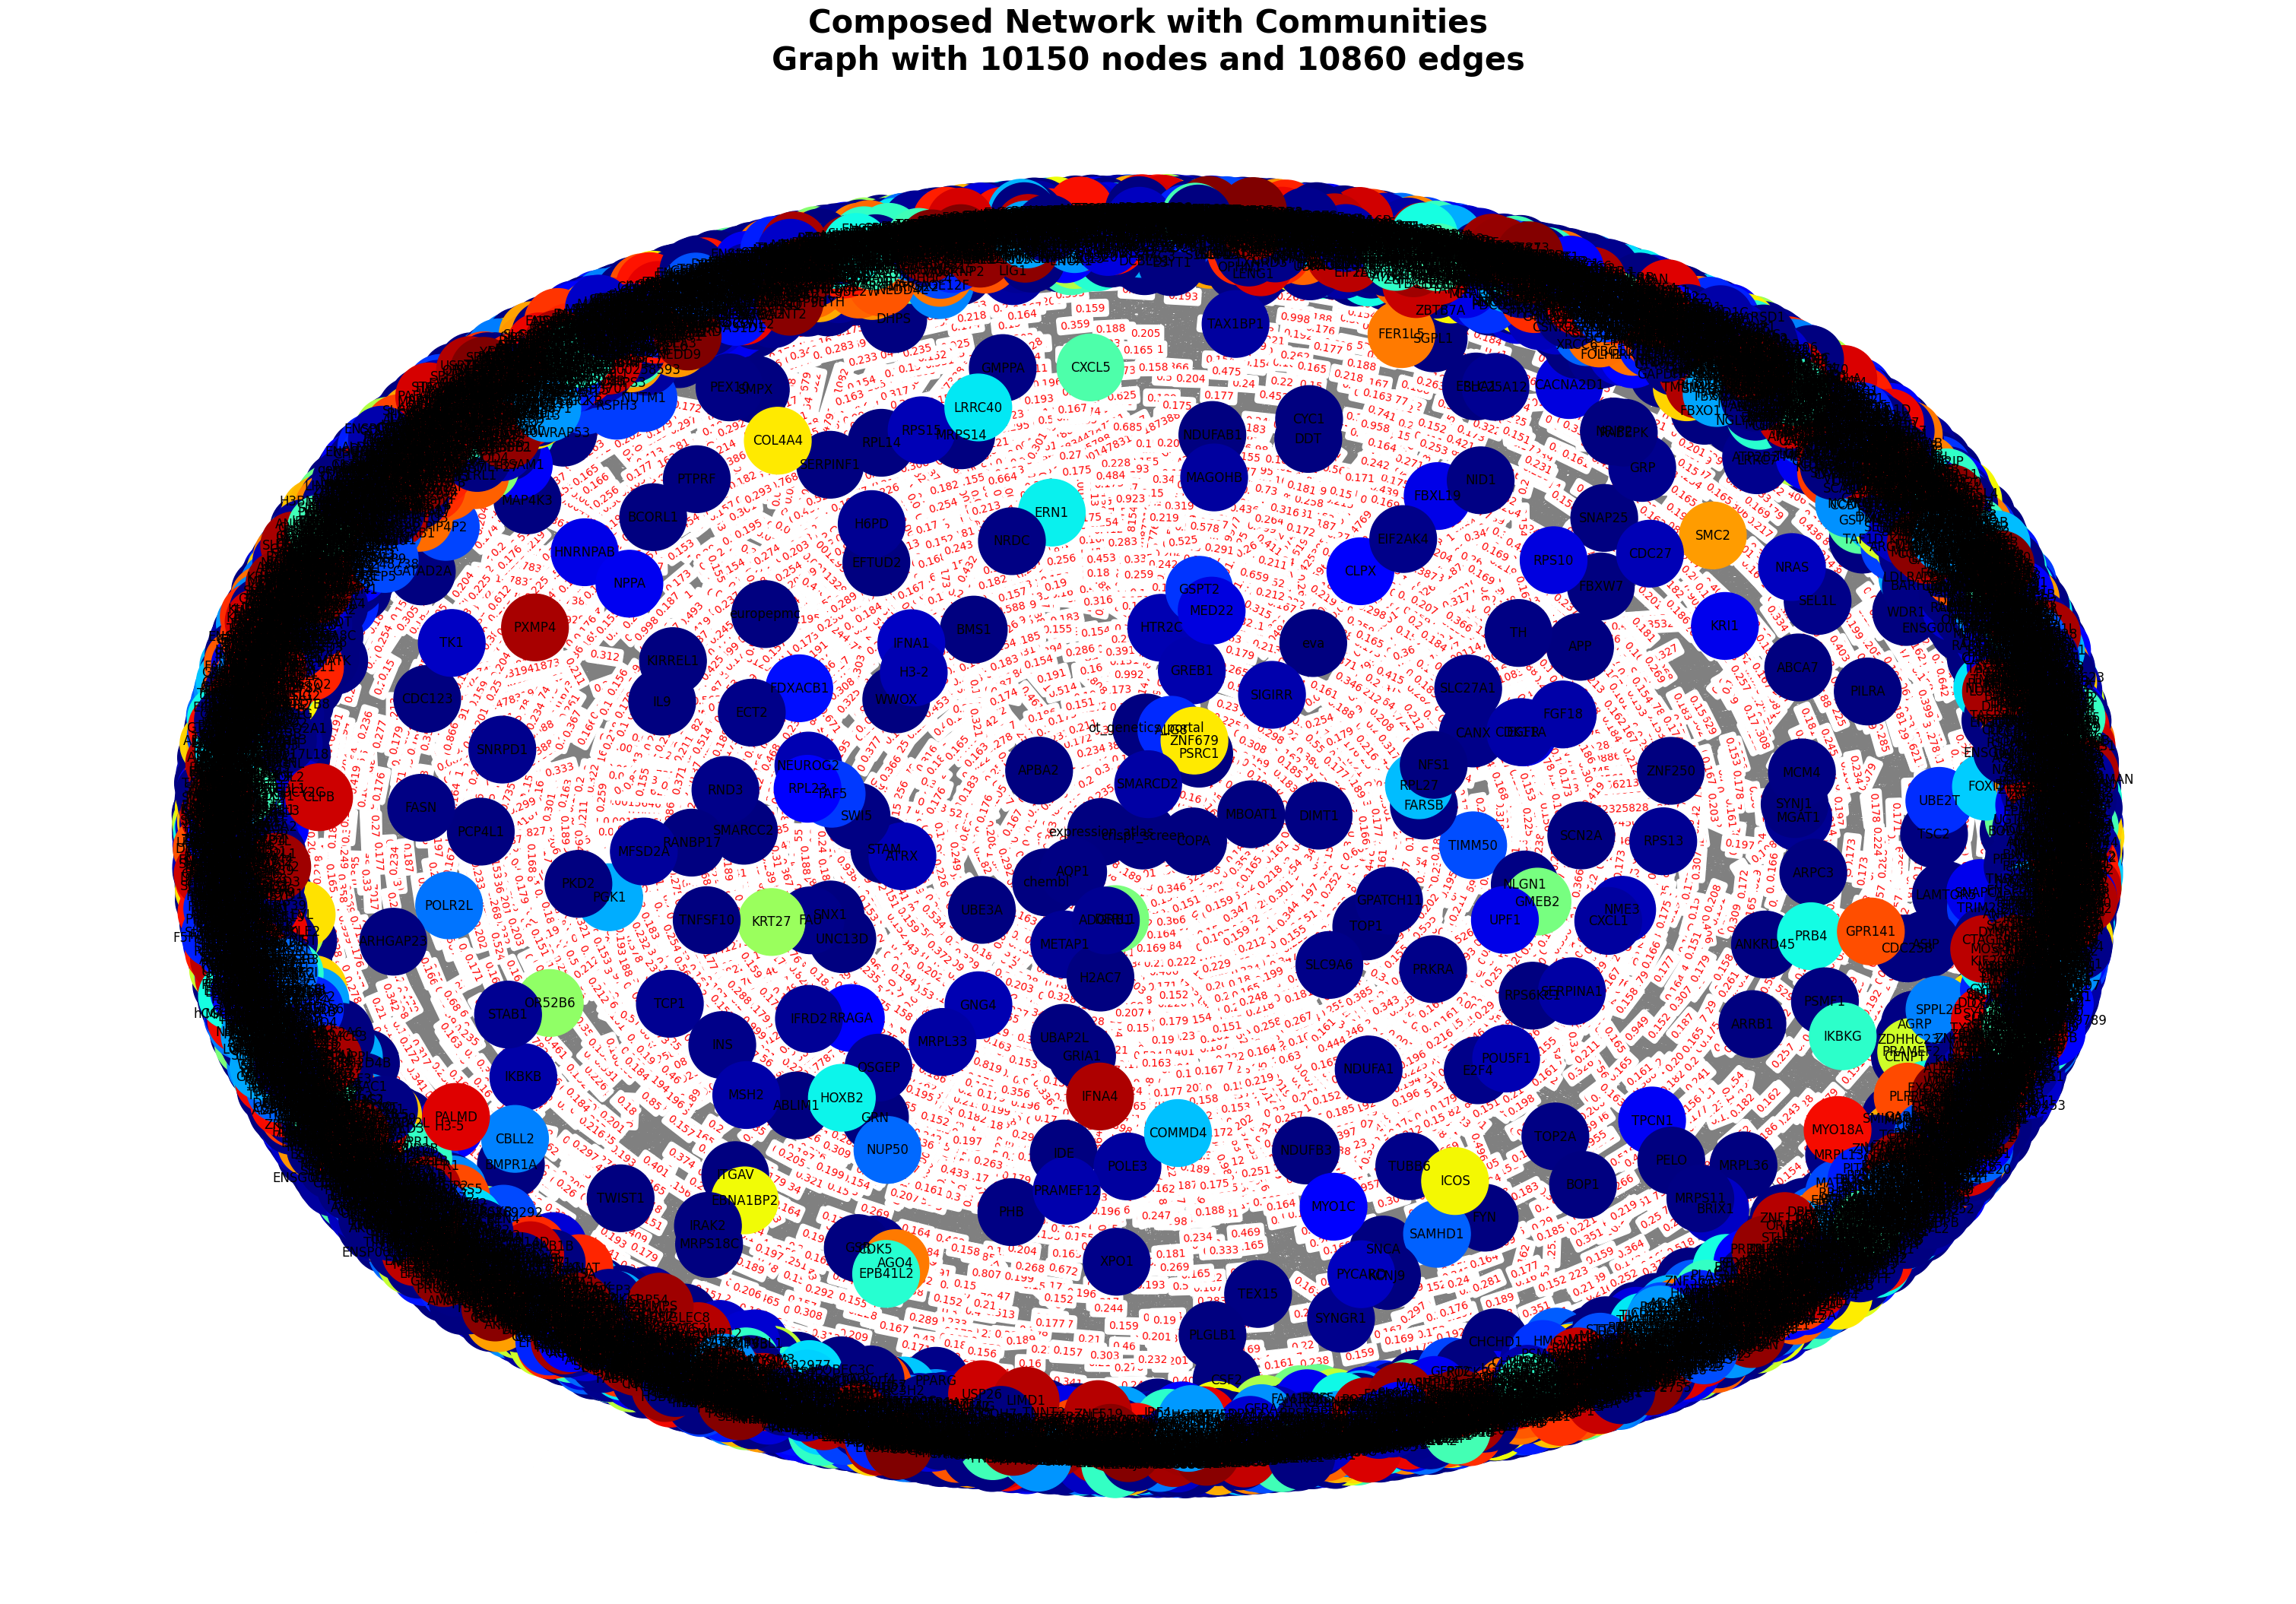

In [8]:
t0 = time.time()

# Create a graph for disease-gene interactions
disease_graph = nx.Graph()
for _, row in disease_df.iterrows():
    disease_graph.add_edge(
        row['datasource_id'],
        row['target_approved_symbol'],
        weight=row['overall_direct_score'],
        type='disease-gene',
    )

# Create a graph for protein-protein interactions
string_graph = nx.Graph()
for _, row in sample_string_interactions.iterrows():
    string_graph.add_edge(
        row['protein1_name'],
        row['protein2_name'],
        weight=row['combined_score'],
        type='protein-protein'
    )

# Time taken to construct both graphs
print(f'Graphs construction completed at {time.time() - t0:.2f} seconds')

t1 = time.time()
# Compose the two graphs into a single graph
composed_graph = nx.compose(disease_graph, string_graph)
print(f'Graphs composed at {time.time() - t1:.2f} seconds')

# Save the composed graph and plot the community detection results
nx.write_graphml(composed_graph, "../data/processed/alzheimer_mini_composed_graph.graphml")
plot_community_detection(
    composed_graph,
    edge_attr_col='weight',
    plot=True,
    save=True,
    filename="../docs/assets/alzheimer_mini_composed_graph.png"
)

In [9]:
edges_data = []
for u, v, data in composed_graph.edges(data=True):
    edges_data.append({
        'source': u,
        'target': v,
        'weight': data.get('weight'),
        'type': data.get('type')
    })

alzheimer_merged_df = pd.DataFrame(edges_data)
alzheimer_merged_df.to_csv('../data/processed/alzheimer_mini_merged_dataset.txt', sep='\t', index=False)
alzheimer_merged_df

source   target    weight             type
0      ot_genetics_portal      APP  0.752949     disease-gene
1      ot_genetics_portal   GRIN3B  0.607722     disease-gene
2      ot_genetics_portal    SORL1  0.597072     disease-gene
3      ot_genetics_portal     APOE  0.572144     disease-gene
4      ot_genetics_portal   SCARB1  0.533193     disease-gene
...                   ...      ...       ...              ...
10855               DDX31    ZNF71  0.261000  protein-protein
10856             SLC26A5     CBR3  0.167000  protein-protein
10857                DIO1  SULT1A3  0.154000  protein-protein
10858            MPHOSPH6    SNRPF  0.305000  protein-protein
10859               PCSK4     GOPC  0.319000  protein-protein

[10860 rows x 4 columns]

In [10]:
# # Load the composed graph
#composed_graph = nx.read_graphml("../data/processed/alzheimer_mini_composed_graph.graphml")

# # load the merged dataframe
# alzheimer_merged_df = pd.read_csv('../data/processed/alzheimer_mini_merged_dataset.txt', sep='\t', header=0)

In [11]:
edges = list(composed_graph.edges(data=True))
non_edges = list(nx.non_edges(composed_graph))

positive_samples = [(u, v, 1, d) for u, v, d in edges]
negative_samples = [(u, v, 0, {'weight': 0}) for u, v in random.sample(non_edges, len(edges))]

samples = positive_samples + negative_samples
random.shuffle(samples)

print(f'all samples: {len(samples)}')
print(f'positive samples: {len(positive_samples)}')
print(f'negative samples: {len(negative_samples)}')

# Extracting only the weight feature
X = [[d['weight']] for _, _, _, d in samples]
y = [label for _, _, label, _ in samples]

print(f'Sample from X: {X[0]}')
print(f'Sample from y: {y[0]}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

all samples: 21720
positive samples: 10860
negative samples: 10860
Sample from X: [0]
Sample from y: 0


In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3]}
}

results = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Store test set results
    results[name] = {
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'test_auc': roc_auc_score(y_test, y_test_pred_proba)
    }

for name, metrics in results.items():
    print(f"{name} (Test Set):")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Logistic Regression (Test Set):
  test_accuracy: 0.8352
  test_precision: 1.0000
  test_recall: 0.6693
  test_f1: 0.8019
  test_auc: 1.0000
Random Forest (Test Set):
  test_accuracy: 1.0000
  test_precision: 1.0000
  test_recall: 1.0000
  test_f1: 1.0000
  test_auc: 1.0000
Gradient Boosting (Test Set):
  test_accuracy: 1.0000
  test_precision: 1.0000
  test_recall: 1.0000
  test_f1: 1.0000
  test_auc: 1.0000


Logistic Regression (Validation Set):
  val_accuracy: 0.8533
  val_precision: 1.0000
  val_recall: 0.7027
  val_f1: 0.8254
  val_auc: 1.0000


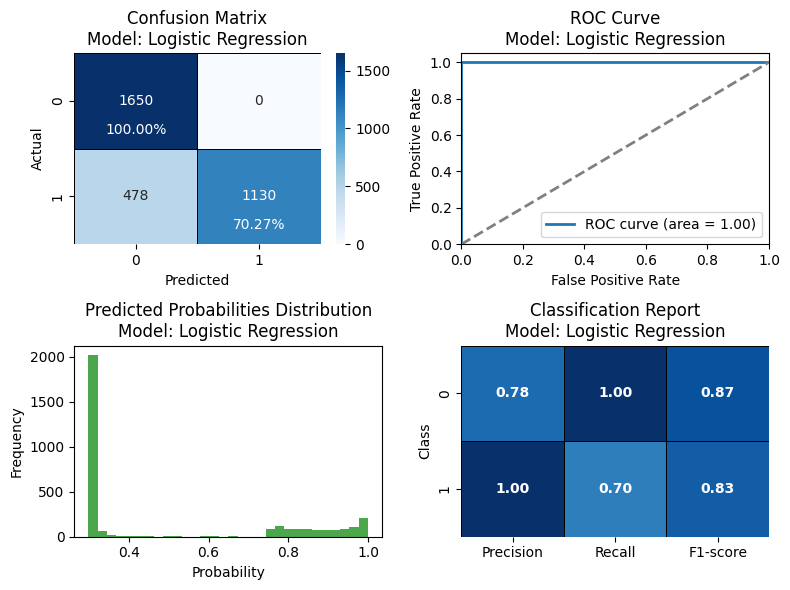

Random Forest (Validation Set):
  val_accuracy: 1.0000
  val_precision: 1.0000
  val_recall: 1.0000
  val_f1: 1.0000
  val_auc: 1.0000


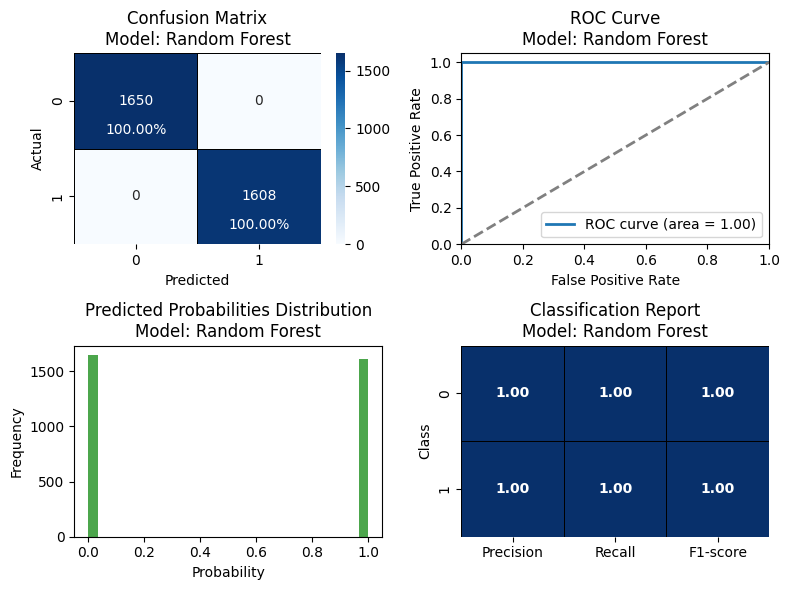

Gradient Boosting (Validation Set):
  val_accuracy: 1.0000
  val_precision: 1.0000
  val_recall: 1.0000
  val_f1: 1.0000
  val_auc: 1.0000


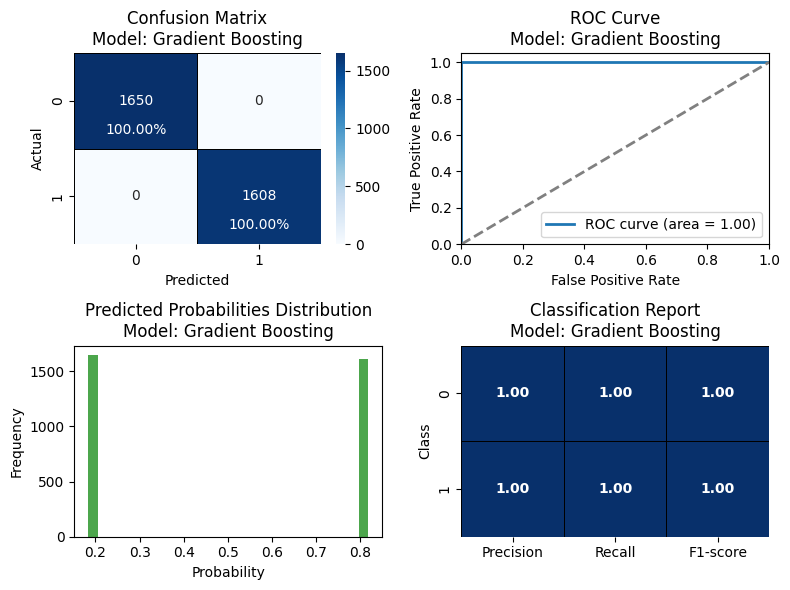

In [13]:
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_val_pred = best_model.predict(X_val)
    y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

    val_metrics = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_auc': roc_auc_score(y_val, y_val_pred_proba)
    }

    print(f"{name} (Validation Set):")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.4f}")

    visualizer = ModelEvaluation(y_val, y_val_pred, model=name)
    visualizer.plot_results(best_model, X_val)

# Experiment 2: Using the full Database and Logistic Regression Modeling

In this experiment, we use the full STRING database to construct a graph for protein-protein interactions and combine it with the disease-gene interaction graph from `disease_df`. We then evaluate the performance of a Logistic Regression model on this full dataset

In [12]:
string_interactions

protein1              protein2 protein1_name  \
0         9606.ENSP00000000233  9606.ENSP00000356607          ARF5   
1         9606.ENSP00000000233  9606.ENSP00000427567          ARF5   
2         9606.ENSP00000000233  9606.ENSP00000253413          ARF5   
3         9606.ENSP00000000233  9606.ENSP00000493357          ARF5   
4         9606.ENSP00000000233  9606.ENSP00000324127          ARF5   
...                        ...                   ...           ...   
13715399  9606.ENSP00000501317  9606.ENSP00000475489          RFX7   
13715400  9606.ENSP00000501317  9606.ENSP00000370447          RFX7   
13715401  9606.ENSP00000501317  9606.ENSP00000312272          RFX7   
13715402  9606.ENSP00000501317  9606.ENSP00000402092          RFX7   
13715403  9606.ENSP00000501317  9606.ENSP00000404074          RFX7   

         protein2_name  protein1_size  protein2_size  combined_score  \
0              RALGPS2            180            583           0.173   
1                FHDC1            180           1143           0.154   
2             ATP6V1E1            180            226           0.151   
3                CYTH2            180            400           0.471   
4                 PSD3            180           1047           0.201   
...                ...            ...            ...             ...   
13715399      MPHOSPH9           1460           1183           0.195   
13715400           VCX           1460            206           0.158   
13715401         YPEL2           1460            119           0.226   
13715402         SAMD3           1460            544           0.169   
13715403        ZSCAN9           1460            445           0.251   

          neighborhood  fusion  cooccurence  coexpression  experimental  \
0                    0       0            0            45           134   
1                    0       0            0             0           128   
2                    0       0            0           118            49   
3                    0       0            0            56            53   
4                    0       0            0             0            46   
...                ...     ...          ...           ...           ...   
13715399             0       0            0            60            99   
13715400             0       0            0            55           111   
13715401             0       0            0             0             0   
13715402             0       0            0             0            67   
13715403             0       0            0            49            63   

          database  textmining  
0                0          81  
1                0          70  
2                0          69  
3                0         457  
4                0         197  
...            ...         ...  
13715399         0         126  
13715400         0          79  
13715401         0         227  
13715402         0         146  
13715403         0         227  

[13715404 rows x 14 columns]

In [13]:
disease_df

target_id target_approved_symbol     disease_id  \
0     ENSG00000142192                    APP  MONDO_0004975   
1     ENSG00000142192                    APP  MONDO_0004975   
2     ENSG00000142192                    APP  MONDO_0004975   
3     ENSG00000142192                    APP  MONDO_0004975   
4     ENSG00000142192                    APP  MONDO_0004975   
...               ...                    ...            ...   
5978  ENSG00000094916                   CBX5  MONDO_0004975   
5979  ENSG00000075303               SLC25A40  MONDO_0004975   
5980  ENSG00000116001                   TIA1  MONDO_0004975   
5981  ENSG00000155886                SLC24A2  MONDO_0004975   
5982  ENSG00000166454                  ATMIN  MONDO_0004975   

           disease_name  overall_direct_score       datasource_id  \
0     Alzheimer disease              0.752949  ot_genetics_portal   
1     Alzheimer disease              0.752949  ot_genetics_portal   
2     Alzheimer disease              0.752949  ot_genetics_portal   
3     Alzheimer disease              0.752949  ot_genetics_portal   
4     Alzheimer disease              0.752949              chembl   
...                 ...                   ...                 ...   
5978  Alzheimer disease              0.001051    expression_atlas   
5979  Alzheimer disease              0.001033    expression_atlas   
5980  Alzheimer disease              0.001028    expression_atlas   
5981  Alzheimer disease              0.001017    expression_atlas   
5982  Alzheimer disease              0.001016    expression_atlas   

     datasource_datatype_id  datasource_direct_score  \
0       genetic_association                 0.465692   
1       genetic_association                 0.465692   
2       genetic_association                 0.465692   
3       genetic_association                 0.465692   
4                known_drug                 0.912335   
...                     ...                      ...   
5978         rna_expression                 0.008642   
5979         rna_expression                 0.008496   
5980         rna_expression                 0.008456   
5981         rna_expression                 0.008363   
5982         rna_expression                 0.008358   

      datasource_direct_evidence_count          datatype_id  \
0                                    1           known_drug   
1                                    1     affected_pathway   
2                                    1           literature   
3                                    1  genetic_association   
4                                   90           known_drug   
...                                ...                  ...   
5978                                 1       rna_expression   
5979                                 1       rna_expression   
5980                                 1       rna_expression   
5981                                 1       rna_expression   
5982                                 1       rna_expression   

      datatype_direct_score  datatype_direct_evidence_count  \
0                  0.912335                              90   
1                  0.607931                               1   
2                  0.365378                              54   
3                  0.818363                             333   
4                  0.912335                              90   
...                     ...                             ...   
5978               0.008642                               1   
5979               0.008496                               1   
5980               0.008456                               1   
5981               0.008363                               1   
5982               0.008358                               1   

      overall_indirect_score  overall_indirect_evidence_count  
0                   0.843813                             1263  
1                   0.843813                             1263  
2                   0.843813                   

In [14]:
t0 = time.time()

# Create a graph for disease-gene interactions
disease_graph = nx.Graph()
for _, row in disease_df.iterrows():
    disease_graph.add_edge(
        row['datasource_id'],
        row['target_approved_symbol'],
        weight=row['overall_direct_score'],
        type='disease-gene',
    )

# Create a graph for protein-protein interactions
string_graph = nx.Graph()
for _, row in string_interactions.iterrows():
    string_graph.add_edge(
        row['protein1_name'],
        row['protein2_name'],
        weight=row['combined_score'],
        type='protein-protein'
    )

# Time taken to construct both graphs
print(f'Graphs construction completed at {time.time() - t0:.2f} seconds')

t1 = time.time()
# Compose the two graphs into a single graph
composed_graph = nx.compose(disease_graph, string_graph)
print(f'Graphs composed at {time.time() - t1:.2f} seconds')

# Save the composed graph and plot the community detection results
nx.write_graphml(composed_graph, "../data/processed/alzheimer_full_composed_graph.graphml")

Graphs construction completed at 498.02 seconds
Graphs composed at 13.94 seconds


In [15]:
# Number of nodes in the graph
num_nodes = composed_graph.number_of_nodes()
print(f'Number of nodes: {num_nodes}')

# Number of edges in the graph
num_edges = composed_graph.number_of_edges()
print(f'Number of edges: {num_edges}')


Number of nodes: 19801
Number of edges: 6862582


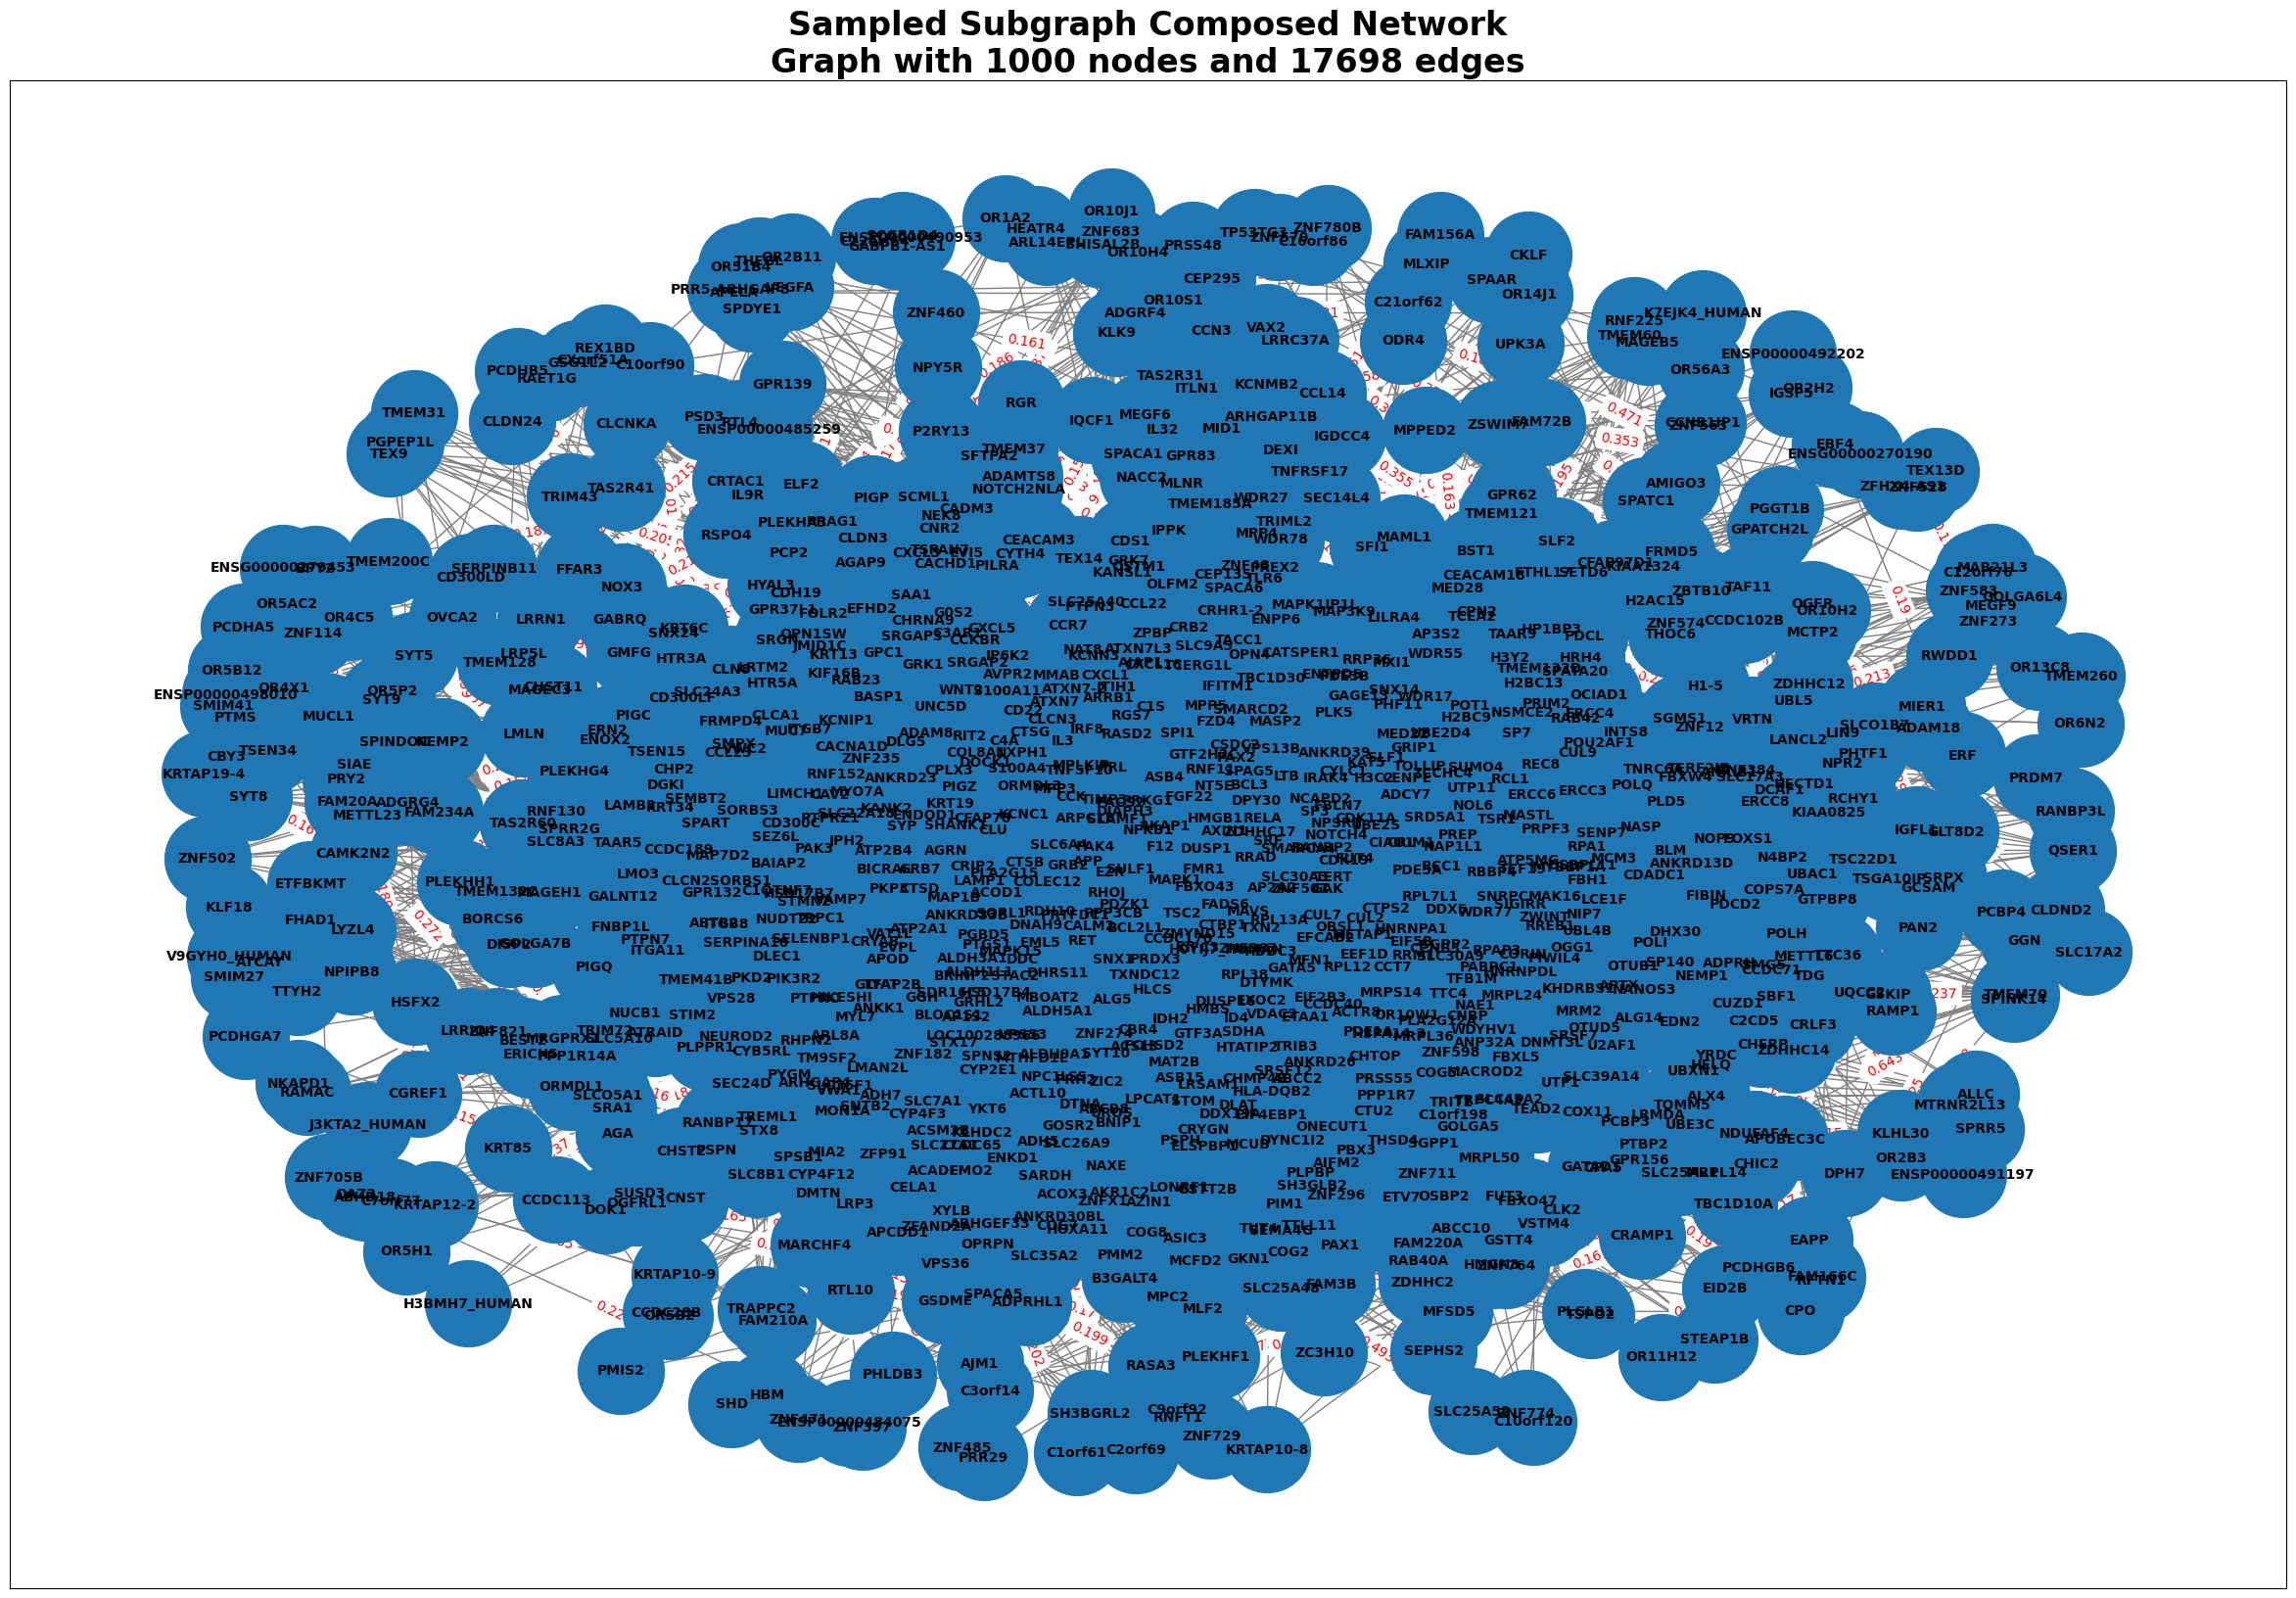

In [16]:
plt.figure(figsize=(30, 20))
sample_size = 1000

sampled_nodes = random.sample(list(composed_graph.nodes()), sample_size)
sampled_graph = composed_graph.subgraph(sampled_nodes)

pos = nx.spring_layout(sampled_graph, seed=42, k=0.7, iterations=100)
nx.draw_networkx(sampled_graph, pos, with_labels=True, edge_color="gray", node_size=4000, font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(sampled_graph, pos, edge_labels=nx.get_edge_attributes(sampled_graph, 'weight'), font_color='red')

plt.title(f"Sampled Subgraph Composed Network\n{sampled_graph}", fontsize=24, fontweight='bold')
plt.show()

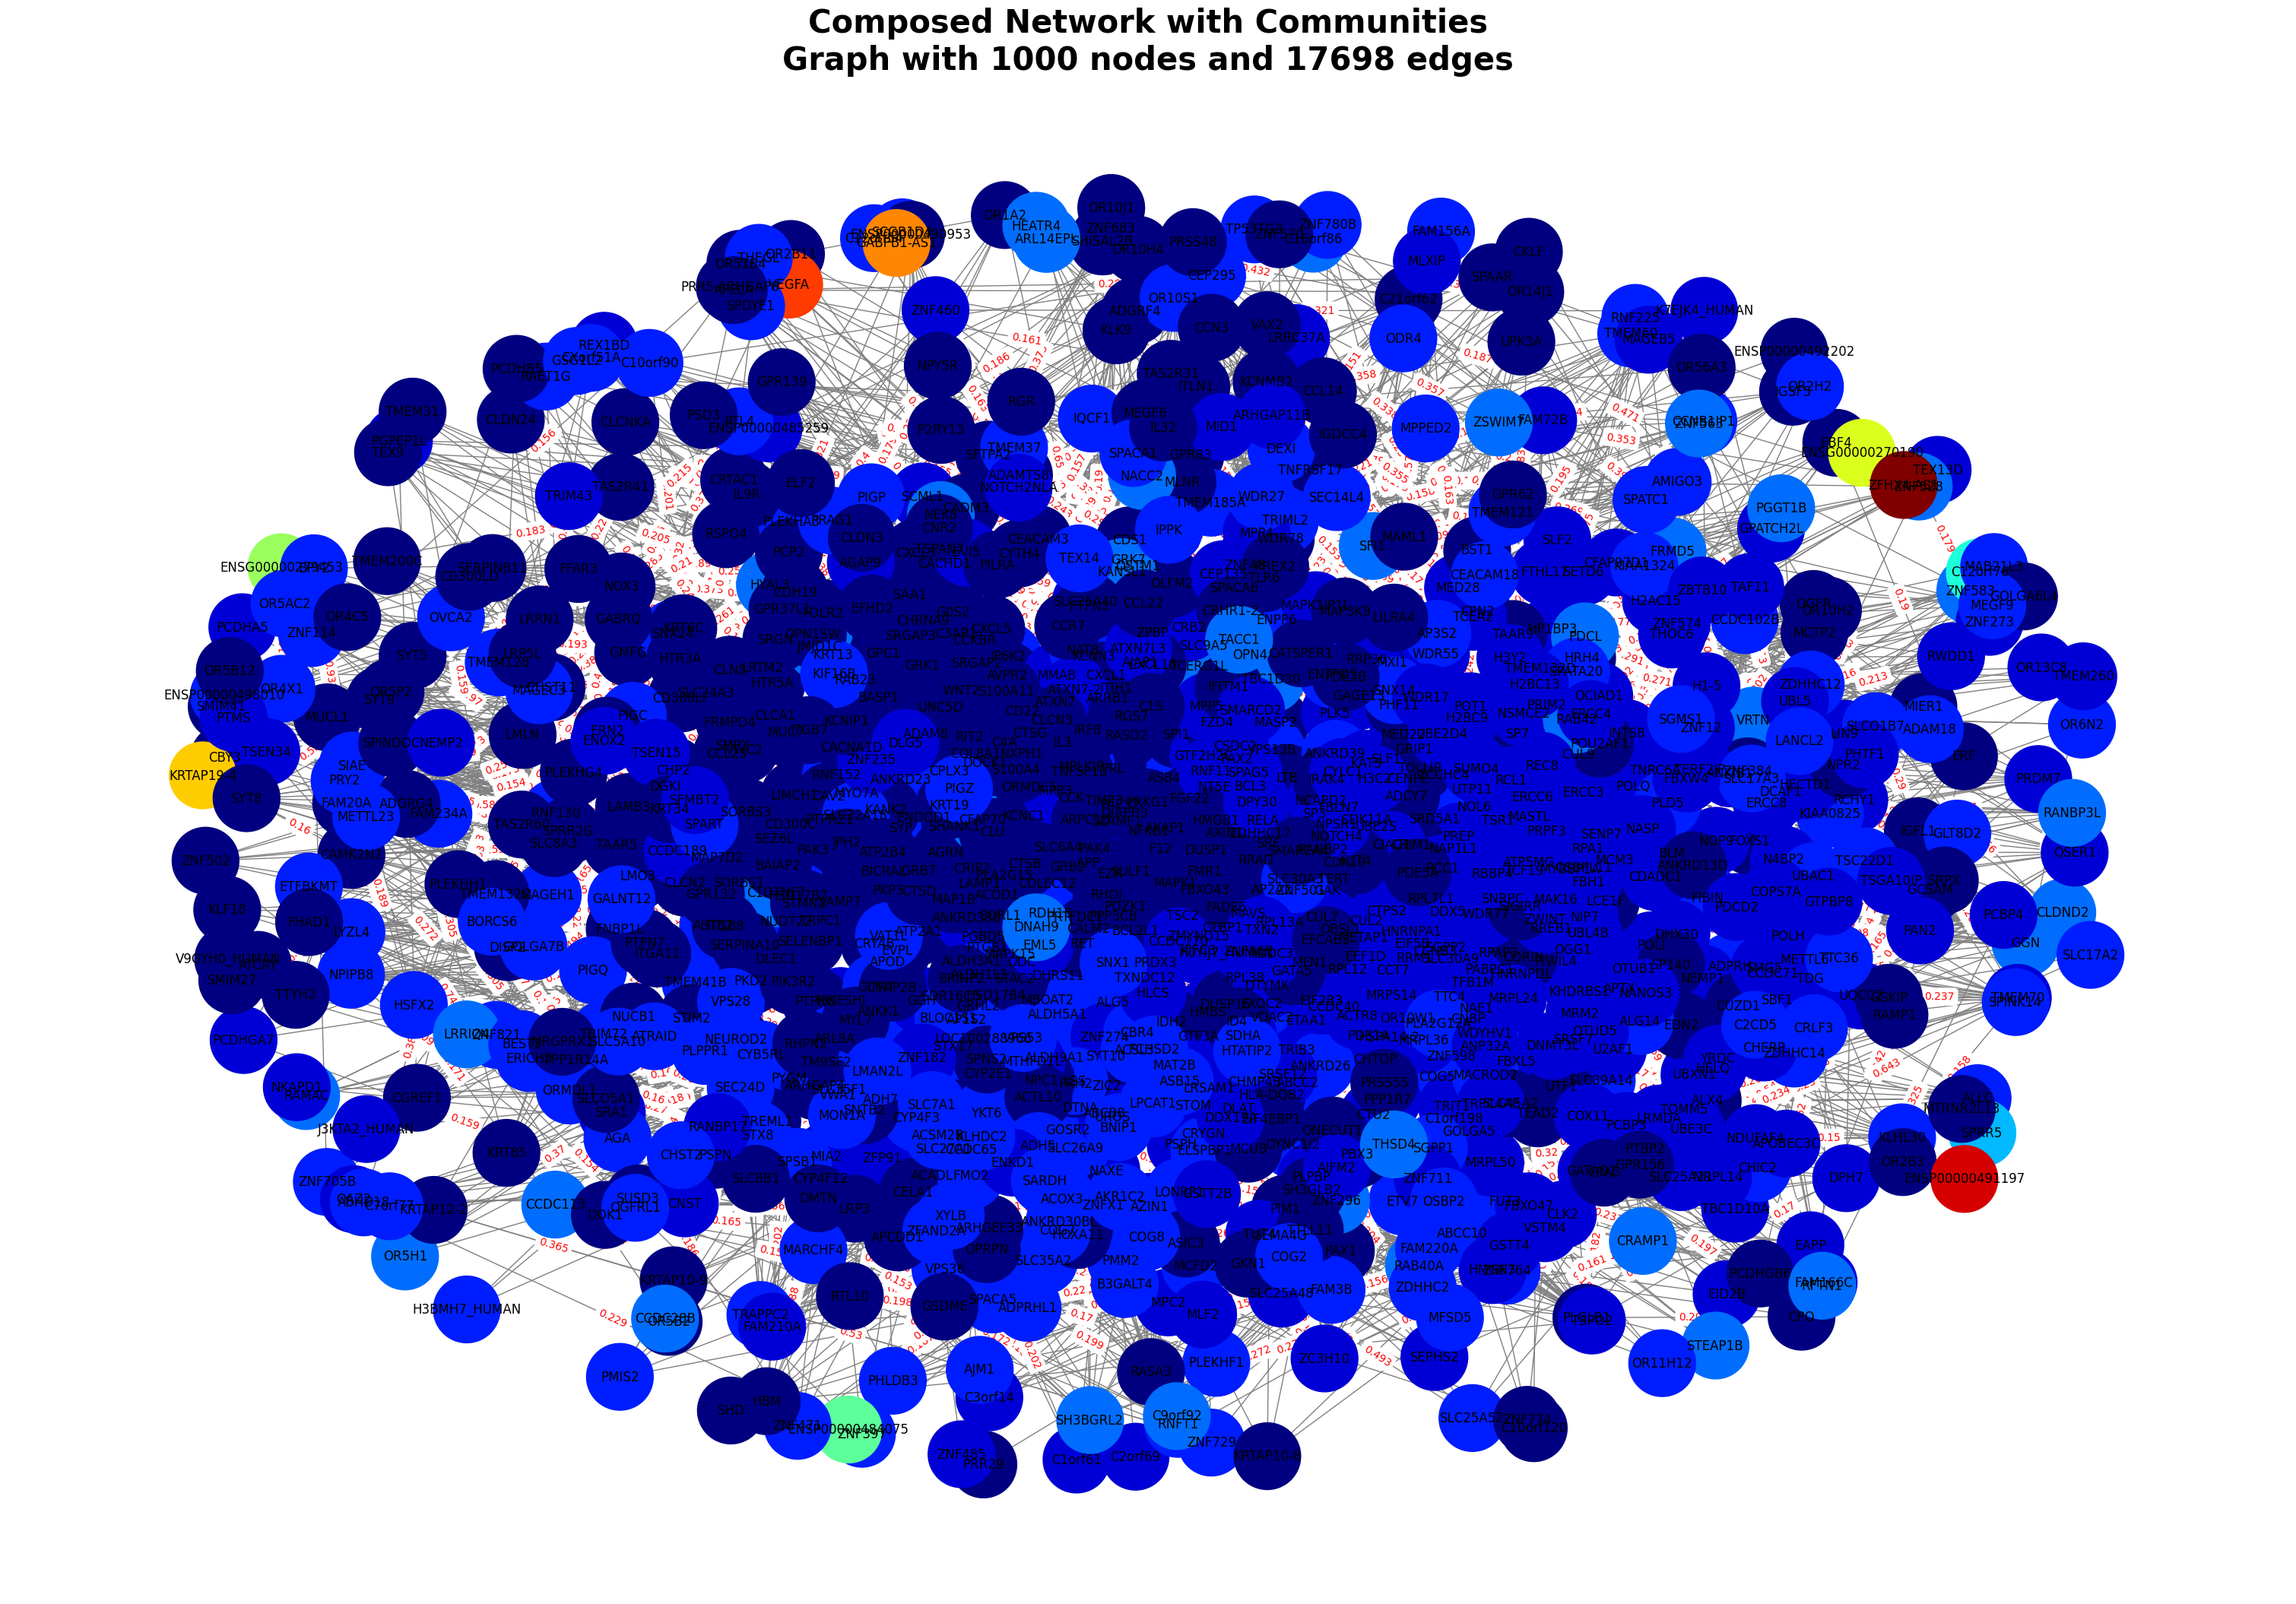

In [17]:
plot_community_detection(
    sampled_graph,
    edge_attr_col='weight',
    plot=True,
)

In [18]:
edges_data = []
for u, v, data in composed_graph.edges(data=True):
    edges_data.append({
        'source': u,
        'target': v,
        'weight': data.get('weight'),
        'type': data.get('type')
    })

alzheimer_merged_df = pd.DataFrame(edges_data)
alzheimer_merged_df.to_csv('../data/processed/alzheimer_full_merged_dataset.txt', sep='\t', index=False)
alzheimer_merged_df

source     target    weight             type
0        ot_genetics_portal        APP  0.752949     disease-gene
1        ot_genetics_portal     GRIN3B  0.607722     disease-gene
2        ot_genetics_portal      SORL1  0.597072     disease-gene
3        ot_genetics_portal       APOE  0.572144     disease-gene
4        ot_genetics_portal     SCARB1  0.533193     disease-gene
...                     ...        ...       ...              ...
6862577           KRTAP22-1  KRTAP21-3  0.208000  protein-protein
6862578           KRTAP22-1     SCYGR1  0.794000  protein-protein
6862579           KRTAP21-3  KRTAP22-2  0.157000  protein-protein
6862580           KRTAP20-3  KRTAP22-2  0.216000  protein-protein
6862581                ETDA     SCYGR1  0.597000  protein-protein

[6862582 rows x 4 columns]

In [19]:
edges = list(composed_graph.edges(data=True))
non_edges = list(nx.non_edges(composed_graph))

positive_samples = [(u, v, 1, d) for u, v, d in edges]
negative_samples = [(u, v, 0, {'weight': 0}) for u, v in random.sample(non_edges, len(edges))]

samples = positive_samples + negative_samples
random.shuffle(samples)

print(f'all samples: {len(samples)}')
print(f'positive samples: {len(positive_samples)}')
print(f'negative samples: {len(negative_samples)}')

# Extracting only the weight feature
X = [[d['weight']] for _, _, _, d in samples]
y = [label for _, _, label, _ in samples]

print(f'Sample from X: {X[0]}')
print(f'Sample from y: {y[0]}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

all samples: 13725164
positive samples: 6862582
negative samples: 6862582
Sample from X: [0.16]
Sample from y: 1


In [20]:
model = LogisticRegression(solver='liblinear', C=1, penalty='l2')
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

results = {
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'test_precision': precision_score(y_test, y_test_pred),
    'test_recall': recall_score(y_test, y_test_pred),
    'test_f1': f1_score(y_test, y_test_pred),
    'test_auc': roc_auc_score(y_test, y_test_pred_proba)
}

print("Logistic Regression (Test Set):")
for metric, value in results.items():
    print(f"  {metric}: {value:.4f}")

Logistic Regression (Test Set):
  test_accuracy: 0.9997
  test_precision: 1.0000
  test_recall: 0.9995
  test_f1: 0.9997
  test_auc: 1.0000


Logistic Regression (Validation Set):
  val_accuracy: 0.9998
  val_precision: 1.0000
  val_recall: 0.9995
  val_f1: 0.9998
  val_auc: 1.0000


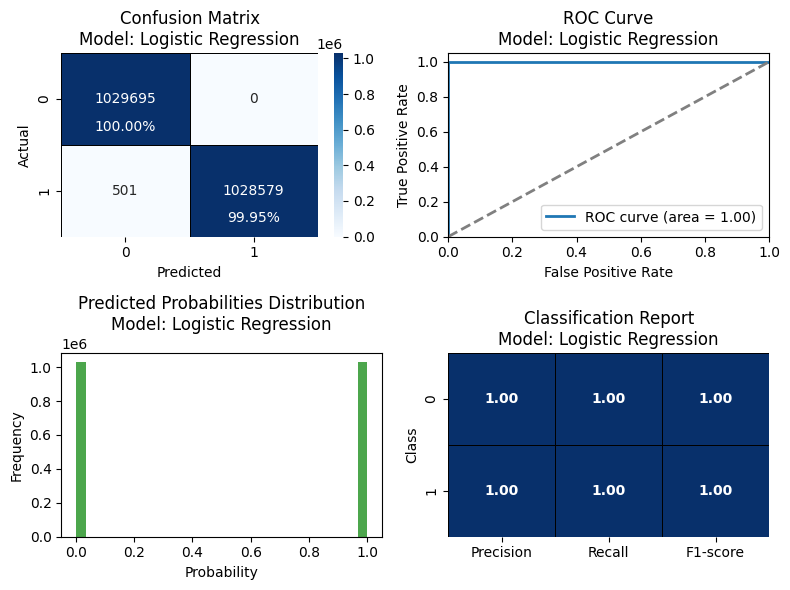

In [20]:
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

val_metrics = {
    'val_accuracy': accuracy_score(y_val, y_val_pred),
    'val_precision': precision_score(y_val, y_val_pred),
    'val_recall': recall_score(y_val, y_val_pred),
    'val_f1': f1_score(y_val, y_val_pred),
    'val_auc': roc_auc_score(y_val, y_val_pred_proba)
}

print(f"Logistic Regression (Validation Set):")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")

visualizer = ModelEvaluation(y_val, y_val_pred, model="Logistic Regression")
visualizer.plot_results(model, X_val)

In [21]:
# Save the model
dump(model, '../models/LR_alzheimer.joblib')

['../models/LR_alzheimer.joblib']